## IDS 566 Project - SP22

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from wordcloud import WordCloud

from sklearn import model_selection, preprocessing, metrics, svm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
import pandas as pd
import numpy as np
import nltk, string
import spacy, pickle
import warnings
from nltk.corpus import stopwords
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt # for data visualization purposes
import seaborn as sns # for statistical data visualization
import gensim
from collections import defaultdict, Counter
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer,WordNetLemmatizer
from textblob import TextBlob
%matplotlib inline
from sklearn.model_selection import cross_val_score
import time
import en_core_web_sm, nltk, string, re
from bs4 import BeautifulSoup
# Loading model
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB

### Here we are importing the combine dataset of train, test and validation as one dataset which will be split further before model training

In [8]:
train = pd.read_csv("liar_data.csv")

In [9]:
train.drop(columns=['Unnamed: 0'],inplace=True)

In [10]:
train.columns = ['id',  # Column 1: the ID of the statement ([ID].json).
        'label',             # Column 2: the label.
        'statement',         # Column 3: the statement.
        'subjects',          # Column 4: the subject(s).
        'speaker',           # Column 5: the speaker.
        'speaker_job_title', # Column 6: the speaker's job title.
        'state_info',        # Column 7: the state info.
        'party_affiliation', # Column 8: the party affiliation.
        'count_1', # barely true counts.
        'count_2', # false counts.
        'count_3', # half true counts.
        'count_4', # mostly true counts.
        'count_5', # pants on fire counts.
        'context']

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12790 entries, 0 to 12789
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 12790 non-null  object 
 1   label              12790 non-null  object 
 2   statement          12790 non-null  object 
 3   subjects           12788 non-null  object 
 4   speaker            12788 non-null  object 
 5   speaker_job_title  9223 non-null   object 
 6   state_info         10041 non-null  object 
 7   party_affiliation  12788 non-null  object 
 8   count_1            12788 non-null  float64
 9   count_2            12788 non-null  float64
 10  count_3            12788 non-null  float64
 11  count_4            12788 non-null  float64
 12  count_5            12788 non-null  float64
 13  context            12659 non-null  object 
dtypes: float64(5), object(9)
memory usage: 1.4+ MB


In [12]:
train.isna().sum()

id                      0
label                   0
statement               0
subjects                2
speaker                 2
speaker_job_title    3567
state_info           2749
party_affiliation       2
count_1                 2
count_2                 2
count_3                 2
count_4                 2
count_5                 2
context               131
dtype: int64

In [13]:
train['label'].value_counts()

half-true      2627
FALSE          2506
mostly-true    2454
barely-true    2103
TRUE           2053
pants-fire     1047
Name: label, dtype: int64

In [14]:
def prep(df):   
    df = df.iloc[:,0:3]
    df['label_new'] = df['label'].apply(lambda x: 'True' if x in ('half-true','mostly-true','true') else 'False')
    df.drop(['label'],axis=1,inplace=True)
    return df
train = prep(train)

In [15]:
def data_obs():
    print("training dataset size:")
    print(train.shape)

data_obs()

training dataset size:
(12790, 3)


In [16]:
def plot(df):
    sns.countplot(x='label_new',data=df,palette='hls')

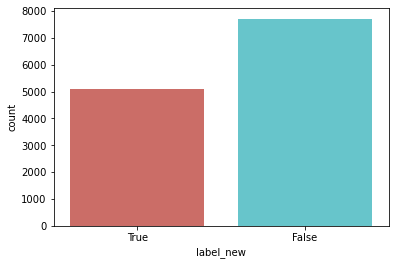

In [17]:
plot(train)

In [18]:
def check_null():
    print(train.isna().sum())
check_null()

id           0
statement    0
label_new    0
dtype: int64


array([<AxesSubplot:title={'center':'False'}>,
       <AxesSubplot:title={'center':'True'}>], dtype=object)

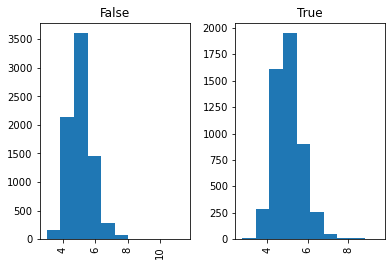

In [19]:
# The word distribution among the text of the news 
trainCopy=train.copy()
trainCopy['statement'].str.split().apply(lambda x:[len(i) for i in x]).map(lambda x: np.mean(x)).hist(by=trainCopy['label_new'])

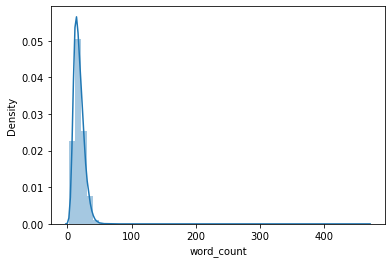

In [20]:
# The word count of the text is distributed amoung the 0 and around 60 words
trainCopy['word_count'] = trainCopy['statement'].apply(lambda x: len(str(x).split()))
sns.distplot(trainCopy['word_count'])
fig = plt.gcf()

In [21]:
train_n = train.copy()

In [22]:
def pre_process(df_col):
    tokens = word_tokenize(df_col)
    doc = [word for word in tokens if word.isalpha()]
    doc1 = [word.lower() for word in doc]
    stop_words = stopwords.words('english')
    doc2 = [w for w in doc1 if not w in stop_words]
    porter = PorterStemmer()
    doc3 = [porter.stem(word) for word in doc2]
#     lemmatizer = WordNetLemmatizer()
#     doc3 = [lemmatizer.lemmatize(w) for w in doc2]
    doc4 = [w for w in doc3 if not len(w) == 1]
    doc5 = ' '.join(doc4)
    return doc5

In [23]:
train_n['statement_proc']=train_n['statement'].apply(pre_process)
train_n.drop(['statement','id'],axis=1,inplace=True)

In [24]:
train_n.head()

,label_new,statement_proc
0,True,declin coal start start natur ga took start be...
1,True,hillari clinton agre john mccain vote give geo...
2,False,health care reform legisl like mandat free sex...
3,True,econom turnaround start end term
4,False,chicago bear start quarterback last year total...


In [25]:
vectorizer1 = TfidfVectorizer()
doc_vec1 = vectorizer1.fit_transform(train_n['statement_proc'])

In [26]:
train_tfidf = pd.DataFrame(doc_vec1.toarray(),
                   columns=vectorizer1.get_feature_names())

In [27]:
train_tfidf.head()

,aa,aaa,aaron,aarp,aba,abandon,abba,abbott,abc,abdul,...,zika,zimmerman,zinn,zip,zippo,zombi,zone,zoo,zuckerberg,ʺmore
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
train_data1 = pd.concat([train_n,train_tfidf], axis=1)

In [29]:
train_data1

,label_new,statement_proc,aa,aaa,aaron,aarp,aba,abandon,abba,abbott,...,zika,zimmerman,zinn,zip,zippo,zombi,zone,zoo,zuckerberg,ʺmore
0,True,declin coal start start natur ga took start be...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,True,hillari clinton agre john mccain vote give geo...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,False,health care reform legisl like mandat free sex...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,True,econom turnaround start end term,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,False,chicago bear start quarterback last year total...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12785,True,first time decad import account less half oil ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12786,True,say donald trump bankrupt compani twice four time,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12787,False,john mccain georg bush absolut plan univers he...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12788,False,new poll show percent support presid plan refo...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Topic Generation

In [30]:
lda_model=LatentDirichletAllocation(n_components=10,learning_method='online',random_state=42,max_iter=1) 
lda_top=lda_model.fit_transform(train_tfidf)

In [31]:
train_tfidf.iloc[0]

aa            0.0
aaa           0.0
aaron         0.0
aarp          0.0
aba           0.0
             ... 
zombi         0.0
zone          0.0
zoo           0.0
zuckerberg    0.0
ʺmore         0.0
Name: 0, Length: 8243, dtype: float64

In [32]:
vocab = vectorizer1.get_feature_names()
for i, comp in enumerate(lda_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topic 0: 
clinton hillari mccain john deal iran know crist charli say 

Topic 1: 
women georgia wage abort poverti minimum elimin invest die gone 

Topic 2: 
trump attack donald reagan say paul ronald mexico human endors 

Topic 3: 
say spent border rick trade econom servic scott gov taxpay 

Topic 4: 
never univers check decid stand given background gun favor word 

Topic 5: 
job year obama presid percent sinc offic counti creat two 

Topic 6: 
say tax state health percent care year vote obama billion 

Topic 7: 
walker scott rubio ban water marco percentag equal intern weapon 

Topic 8: 
island florida rhode crime provid marriag rate percent school street 

Topic 9: 
illeg immigr contribut pension stop popul buy muslim fraud tri 



In [33]:
def topic_tag(df):
    train_n['topic1'] =''
    train_n['topic2'] =''
    train_n['topic3'] =''
    train_n['topic4'] =''
    train_n['topic5'] =''
    train_n['topic6'] =''
    train_n['topic7'] =''
    train_n['topic8'] =''
    train_n['topic9'] =''
    train_n['topic10'] =''
    for i in range(df.shape[0]):
#         for k,j in enumerate(train_n.columns[2:]):
#             df[j] = lda_top[i][k]
        df['topic1'].iloc[i] = lda_top[i][0]
        df['topic2'].iloc[i] = lda_top[i][1]
        df['topic3'].iloc[i] = lda_top[i][2]
        df['topic4'].iloc[i] = lda_top[i][3]
        df['topic5'].iloc[i] = lda_top[i][4]
        df['topic6'].iloc[i] = lda_top[i][5]
        df['topic7'].iloc[i] = lda_top[i][6]
        df['topic8'].iloc[i] = lda_top[i][7]
        df['topic9'].iloc[i] = lda_top[i][8]
        df['topic10'].iloc[i] = lda_top[i][9]
    return df
train_t=topic_tag(train_n)

In [34]:
train_t.shape

(12790, 12)

In [35]:
x_f = [train_t[train_t['label_new']=='False']['topic1'].mean(), train_t['topic2'][train_t['label_new']=='False'].mean(), train_t['topic3'][train_t['label_new']=='False'].mean(), train_t['topic4'][train_t['label_new']=='False'].mean(), train_t['topic5'][train_t['label_new']=='False'].mean(), train_t['topic6'][train_t['label_new']=='False'].mean(), train_t['topic7'][train_t['label_new']=='False'].mean(), train_t['topic8'][train_t['label_new']=='False'].mean(), train_t['topic9'][train_t['label_new']=='False'].mean(), train_t['topic10'][train_t['label_new']=='False'].mean()]
x_t = [train_t[train_t['label_new']=='True']['topic1'].mean(), train_t['topic2'][train_t['label_new']=='True'].mean(), train_t['topic3'][train_t['label_new']=='True'].mean(), train_t['topic4'][train_t['label_new']=='True'].mean(), train_t['topic5'][train_t['label_new']=='True'].mean(), train_t['topic6'][train_t['label_new']=='True'].mean(), train_t['topic7'][train_t['label_new']=='True'].mean(), train_t['topic8'][train_t['label_new']=='True'].mean(), train_t['topic9'][train_t['label_new']=='True'].mean(), train_t['topic10'][train_t['label_new']=='True'].mean()]
print(x_t)
print(x_f)
cols= train_t.columns[2:]
cols

[0.06755940095526061, 0.06625944228138522, 0.05827246722155804, 0.0944144350439828, 0.040636969798570774, 0.1196422035016744, 0.34611136033771733, 0.050429422969080324, 0.08024488300211487, 0.0764294148886539]
[0.07314030120042103, 0.0700835383425244, 0.06445300764618606, 0.0956048084043705, 0.04448324925086169, 0.10976327376468217, 0.3307360266971275, 0.05430704389310276, 0.07838110505842939, 0.07904764574229474]


Index(['topic1', 'topic2', 'topic3', 'topic4', 'topic5', 'topic6', 'topic7',
       'topic8', 'topic9', 'topic10'],
      dtype='object')

<AxesSubplot:>

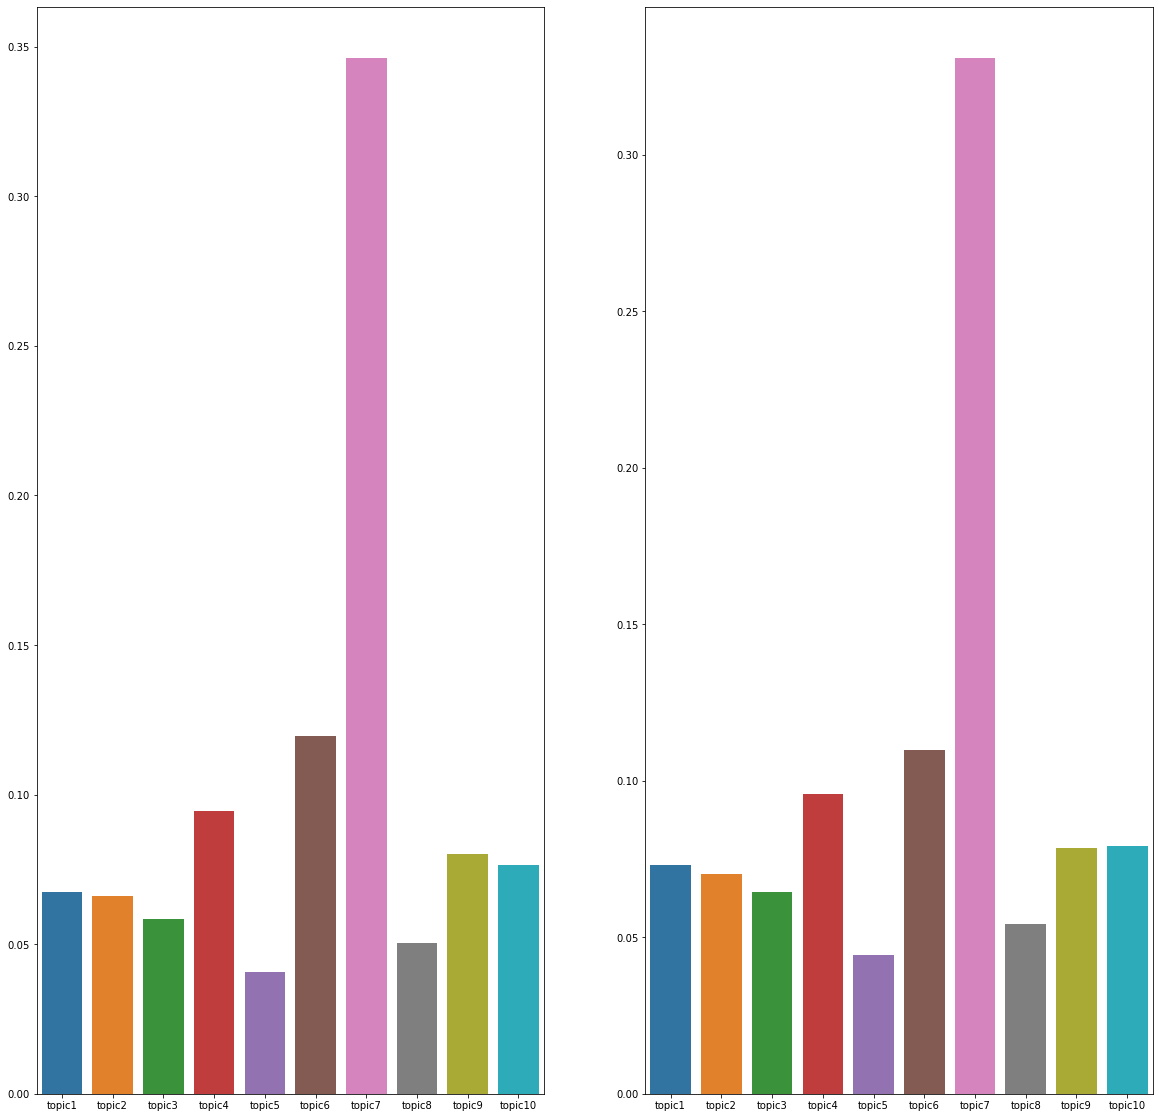

In [36]:
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
sns.barplot(x=cols,y=x_t)
# plt.axis("off")
plt.subplot(1,2,2)
sns.barplot(x=cols,y=x_f)
# plt.axis("off")

In [61]:
text_f = " ".join(review for review in train_t[train_t['label_new']=='False'].statement_proc)
text_t = " ".join(review for review in train_t[train_t['label_new']=='True'].statement_proc)

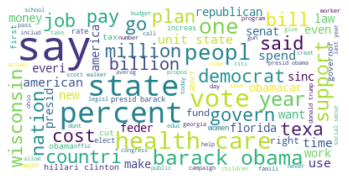

In [62]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text_f)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

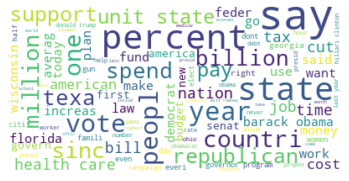

In [63]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text_t)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**Preparing the two datasets for the models**

In [64]:
train_data2 = pd.concat([train_t,train_tfidf], axis=1)

In [65]:
train_data2['topic1']=pd.to_numeric(train_data2['topic1'])
train_data2['topic2']=pd.to_numeric(train_data2['topic2'])
train_data2['topic3']=pd.to_numeric(train_data2['topic3'])
train_data2['topic4']=pd.to_numeric(train_data2['topic4'])
train_data2['topic5']=pd.to_numeric(train_data2['topic5'])
train_data2['topic6']=pd.to_numeric(train_data2['topic6'])
train_data2['topic7']=pd.to_numeric(train_data2['topic7'])
train_data2['topic8']=pd.to_numeric(train_data2['topic8'])
train_data2['topic9']=pd.to_numeric(train_data2['topic9'])
train_data2['topic10']=pd.to_numeric(train_data2['topic10'])

In [66]:
del (train_data1['statement_proc'])
del (train_data2['statement_proc'])

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [68]:
train_data1_X = train_data1.iloc[:,1:]
train_data1_y = train_data1['label_new']
train_data2_X = train_data2.iloc[:,1:]
train_data2_y = train_data2['label_new']

In [69]:
X1 = StandardScaler().fit_transform(train_data1_X)
X2 = StandardScaler().fit_transform(train_data2_X)

In [70]:
X1.shape

(12790, 8244)

In [71]:
X2.shape

(12790, 8254)

In [72]:
from sklearn.decomposition import PCA

pca = PCA(0.95)
principalComponents1 = pca.fit_transform(X1)
principalComponents2 = pca.fit_transform(X2)

pca.explained_variance_ratio_ 

X_train1, X_test1, y_train1, y_test1 = train_test_split(principalComponents1, train_data1_y, test_size=0.3, random_state=42)

X_train2, X_test2, y_train2, y_test2 = train_test_split(principalComponents2, train_data2_y, test_size=0.3, random_state=42)

In [73]:
X_train1.shape

(8953, 5204)

In [74]:
X_train2.shape

(8953, 5204)

In [75]:
from sklearn.model_selection import train_test_split

X_train3, X_test3, y_train3, y_test3 = train_test_split(train_data1_X, train_data1_y, test_size=0.3, random_state=42)

X_train4, X_test4, y_train4, y_test4 = train_test_split(train_data2_X, train_data2_y, test_size=0.3, random_state=42)

**Model Evaluation Function**

In [76]:
def evaluate(model,df,test):
    predictions_SGD = model.predict(df)
    print("****Model Evaluation****")
    print("SGD Accuracy:",metrics.accuracy_score(test, predictions_SGD))
    print('\nClasification report:\n', classification_report(test, predictions_SGD))
    print('\nConfussion matrix:\n',confusion_matrix(test, predictions_SGD))

## Building different machine learning models for fake news detection and their evaluation

### Model 1 - Logistic Classifier

In [45]:
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report ,confusion_matrix

### TFIDF

In [46]:
TFIDFSGD1 = SGDClassifier(loss='log', penalty= 'elasticnet', l1_ratio= 0.05, alpha= 0.01, n_iter_no_change=5).fit(X_train1,y_train1)

In [47]:
# predict the labels on Train and Test dataset
evaluate(TFIDFSGD1,X_train1,y_train1)
evaluate(TFIDFSGD1,X_test1,y_test1)

****Model Evaluation****
SGD Accuracy: 0.8602703004579471

Clasification report:
               precision    recall  f1-score   support

       False       0.86      0.91      0.89      5438
        True       0.85      0.78      0.81      3515

    accuracy                           0.86      8953
   macro avg       0.86      0.85      0.85      8953
weighted avg       0.86      0.86      0.86      8953


Confussion matrix:
 [[4969  469]
 [ 782 2733]]
****Model Evaluation****
SGD Accuracy: 0.5663278603075319

Clasification report:
               precision    recall  f1-score   support

       False       0.62      0.70      0.66      2271
        True       0.46      0.38      0.41      1566

    accuracy                           0.57      3837
   macro avg       0.54      0.54      0.54      3837
weighted avg       0.55      0.57      0.56      3837


Confussion matrix:
 [[1583  688]
 [ 976  590]]


### TFIDF + Topics

In [48]:
TFIDFSGD2 = SGDClassifier(loss='log', penalty= 'elasticnet', l1_ratio= 0.05, alpha= 0.000003, n_iter_no_change=5).fit(X_train2,y_train2)

In [49]:
# predict the labels on Train and Test dataset
evaluate(TFIDFSGD2,X_train2,y_train2)
evaluate(TFIDFSGD2,X_test2,y_test2)

****Model Evaluation****
SGD Accuracy: 0.8785881827320451

Clasification report:
               precision    recall  f1-score   support

       False       0.89      0.91      0.90      5438
        True       0.86      0.83      0.84      3515

    accuracy                           0.88      8953
   macro avg       0.87      0.87      0.87      8953
weighted avg       0.88      0.88      0.88      8953


Confussion matrix:
 [[4958  480]
 [ 607 2908]]
****Model Evaluation****
SGD Accuracy: 0.5373990096429502

Clasification report:
               precision    recall  f1-score   support

       False       0.61      0.62      0.61      2271
        True       0.43      0.41      0.42      1566

    accuracy                           0.54      3837
   macro avg       0.52      0.52      0.52      3837
weighted avg       0.53      0.54      0.54      3837


Confussion matrix:
 [[1415  856]
 [ 919  647]]


### Model 2 - XGBoost

In [50]:
from xgboost import XGBClassifier

### TFIDF

In [51]:
TFIDFXGB1 = XGBClassifier(n_estimators = 200, max_depth=15, reg_lambda =0.1).fit(X_train1,y_train1)

C:\Users\kmashr2\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:37:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [52]:
eval_set = [(X_test1, y_test1)]
TFIDFXGB11=XGBClassifier()
TFIDFXGB12=TFIDFXGB11.fit(X_train1,y_train1,eval_metric="error", eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.42325
[1]	validation_0-error:0.42533
[2]	validation_0-error:0.42898
[3]	validation_0-error:0.42090
[4]	validation_0-error:0.42273
[5]	validation_0-error:0.42168
[6]	validation_0-error:0.41986
[7]	validation_0-error:0.42351
[8]	validation_0-error:0.42403
[9]	validation_0-error:0.41751
[10]	validation_0-error:0.42012
[11]	validation_0-error:0.42142
[12]	validation_0-error:0.42403
[13]	validation_0-error:0.42351
[14]	validation_0-error:0.42690
[15]	validation_0-error:0.43211
[16]	validation_0-error:0.43133
[17]	validation_0-error:0.43185
[18]	validation_0-error:0.43602
[19]	validation_0-error:0.43367
[20]	validation_0-error:0.43315
[21]	validation_0-error:0.43498
[22]	validation_0-error:0.43419
[23]	validation_0-error:0.43941
[24]	validation_0-error:0.44045
[25]	validation_0-error:0.43836
[26]	validation_0-error:0.43341
[27]	validation_0-error:0.44097
[28]	validation_0-error:0.43862
[29]	validation_0-error:0.43576
[30]	validation_0-error:0.43445
[31]	validation_0-

In [53]:
# predict the labels on Train and Test dataset
evaluate(TFIDFXGB12,X_train1,y_train1)
evaluate(TFIDFXGB12,X_test1,y_test1)

****Model Evaluation****
SGD Accuracy: 0.9995532223835586

Clasification report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00      5438
        True       1.00      1.00      1.00      3515

    accuracy                           1.00      8953
   macro avg       1.00      1.00      1.00      8953
weighted avg       1.00      1.00      1.00      8953


Confussion matrix:
 [[5436    2]
 [   2 3513]]
****Model Evaluation****
SGD Accuracy: 0.5738858483189992

Clasification report:
               precision    recall  f1-score   support

       False       0.61      0.78      0.68      2271
        True       0.46      0.28      0.35      1566

    accuracy                           0.57      3837
   macro avg       0.54      0.53      0.52      3837
weighted avg       0.55      0.57      0.55      3837


Confussion matrix:
 [[1767  504]
 [1131  435]]


### TFIDF + Topics

In [54]:
TFIDFXGB2 = XGBClassifier(n_estimators = 200, max_depth=15, reg_lambda =0.05).fit(X_train2,y_train2)

C:\Users\kmashr2\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:55:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [55]:
# predict the labels on Train and Test dataset
evaluate(TFIDFXGB2,X_train2,y_train2)
evaluate(TFIDFXGB2,X_test2,y_test2)

****Model Evaluation****
SGD Accuracy: 0.9995532223835586

Clasification report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00      5438
        True       1.00      1.00      1.00      3515

    accuracy                           1.00      8953
   macro avg       1.00      1.00      1.00      8953
weighted avg       1.00      1.00      1.00      8953


Confussion matrix:
 [[5436    2]
 [   2 3513]]
****Model Evaluation****
SGD Accuracy: 0.5850925201980715

Clasification report:
               precision    recall  f1-score   support

       False       0.61      0.82      0.70      2271
        True       0.48      0.24      0.32      1566

    accuracy                           0.59      3837
   macro avg       0.55      0.53      0.51      3837
weighted avg       0.56      0.59      0.55      3837


Confussion matrix:
 [[1867  404]
 [1188  378]]


### Model 3 - Random Forest Optimizer

In [46]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report

### TFIDF

In [47]:
print("Random Forest Optimization")
RF = RandomForestClassifier()
param_dist = {
    'max_depth': [5,10,15,20,25,30,35,40],
    'n_estimators': [70,80,85,90,100,110,120,130,140]
}
n_iter_search = 20
rs=RandomizedSearchCV(RF,param_dist,n_iter_search)
TFIDFRF = rs.fit(X_train1,y_train1)

Random Forest Optimization


In [49]:
from sklearn.metrics import confusion_matrix
# predict the labels on Train and Test dataset
evaluate(TFIDFRF,X_train1,y_train1)
evaluate(TFIDFRF,X_test1,y_test1)

****Model Evaluation****
SGD Accuracy: 0.9995532223835586

Clasification report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00      5438
        True       1.00      1.00      1.00      3515

    accuracy                           1.00      8953
   macro avg       1.00      1.00      1.00      8953
weighted avg       1.00      1.00      1.00      8953


Confussion matrix:
 [[5437    1]
 [   3 3512]]
****Model Evaluation****
SGD Accuracy: 0.5884805837894188

Clasification report:
               precision    recall  f1-score   support

       False       0.60      0.94      0.73      2271
        True       0.47      0.08      0.13      1566

    accuracy                           0.59      3837
   macro avg       0.54      0.51      0.43      3837
weighted avg       0.55      0.59      0.49      3837


Confussion matrix:
 [[2135  136]
 [1443  123]]


### TFIDF + Topics

In [50]:
print("Random Forest Optimization")
RF = RandomForestClassifier()
param_dist = {
    'max_depth': [5,10,15,20,25,30,35,40],
    'n_estimators': [70,80,85,90,100,110,120,130,140]
}
n_iter_search = 20
rs=RandomizedSearchCV(RF,param_dist,n_iter_search)
TFIDFRF = rs.fit(X_train1,y_train1)

Random Forest Optimization


In [51]:
# predict the labels on Train and Test dataset
evaluate(TFIDFRF,X_train1,y_train1)
evaluate(TFIDFRF,X_test1,y_test1)

****Model Evaluation****
SGD Accuracy: 0.879816821177259

Clasification report:
               precision    recall  f1-score   support

       False       0.84      1.00      0.91      5438
        True       1.00      0.69      0.82      3515

    accuracy                           0.88      8953
   macro avg       0.92      0.85      0.86      8953
weighted avg       0.90      0.88      0.87      8953


Confussion matrix:
 [[5435    3]
 [1073 2442]]
****Model Evaluation****
SGD Accuracy: 0.5936929893145687

Clasification report:
               precision    recall  f1-score   support

       False       0.60      0.98      0.74      2271
        True       0.53      0.04      0.07      1566

    accuracy                           0.59      3837
   macro avg       0.56      0.51      0.41      3837
weighted avg       0.57      0.59      0.47      3837


Confussion matrix:
 [[2215   56]
 [1503   63]]


# Model 04: MultiNomial Naive Bayes

In [78]:
def modelTraining(model, trainX, trainY, testX, testY, fileName=None):
    # cross-validation
    index = ['True News', 'Fake News']
    classifier = model.fit(trainX, trainY)
    predictions = classifier.predict(testX)
    print(metrics.confusion_matrix(testY, predictions))
    print(metrics.accuracy_score(predictions, testY) * 100)
    print( metrics.classification_report(testY, predictions, target_names=['True News', 'Fake News']))
    
    # print the scores on training and test set

    print('Training set score: {:.4f}'.format(classifier.score(trainX, trainY)))

    print('Test set score: {:.4f}'.format(classifier.score(testX, testY)))
    
    cm = metrics.confusion_matrix(testY, predictions)
    cm_matrix = pd.DataFrame(data=cm, index=index, columns=index)
    fig, ax = plt.subplots(figsize = (10,7))
    sns.set(font_scale=1.4) # for label size
    fig = sns.heatmap(cm_matrix, annot=True, fmt='d', cmap="Blues",annot_kws={"size": 16}, linewidths=2, ax=ax, vmax=80,vmin=0)
    ax.set_yticklabels([i for i in index], rotation=1)
    plt.xlabel("Actual",fontsize=15)
    plt.ylabel("Predicted",fontsize=15) 
    figure = fig.get_figure()

    return metrics.accuracy_score(predictions, testY) * 100

# TFIDF

[[2186   85]
 [1482   84]]
59.16080271045088
              precision    recall  f1-score   support

   True News       0.60      0.96      0.74      2271
   Fake News       0.50      0.05      0.10      1566

    accuracy                           0.59      3837
   macro avg       0.55      0.51      0.42      3837
weighted avg       0.56      0.59      0.48      3837

Training set score: 0.6721
Test set score: 0.5916
accuracy:  59.16080271045088
Cross-validation scores for Multinomial Naive bayes with "BoW" :[0.60692351 0.61306533 0.61027359 0.61340782 0.60502793]
Average cross-validation score for Multinomial Naive bayes with "BoW" : 0.6097


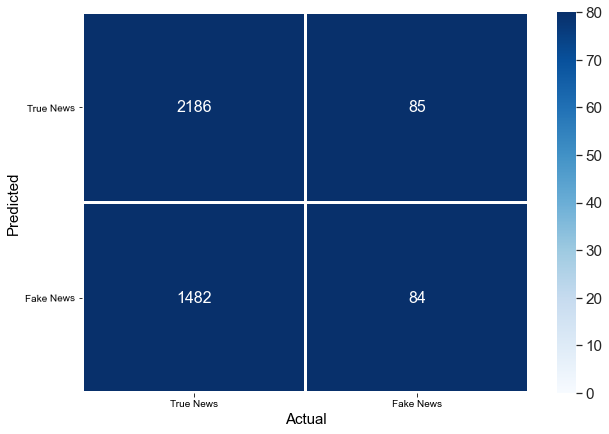

In [79]:
accuracy = modelTraining(MultinomialNB(), X_train3, y_train3, X_test3, y_test3) 
print("accuracy: ", accuracy)

# Applying 5-Fold Cross Validation

from sklearn.model_selection import cross_val_score

scores = cross_val_score(MultinomialNB(), X_train3, y_train3, cv = 5, scoring='accuracy')

print('Cross-validation scores for Multinomial Naive bayes with "BoW" :{}'.format(scores))
print('Average cross-validation score for Multinomial Naive bayes with "BoW" : {:.4f}'.format(scores.mean()))

# TFIDF + Topic Modeling

[[2190   81]
 [1484   82]]
59.21292676570237
              precision    recall  f1-score   support

   True News       0.60      0.96      0.74      2271
   Fake News       0.50      0.05      0.09      1566

    accuracy                           0.59      3837
   macro avg       0.55      0.51      0.42      3837
weighted avg       0.56      0.59      0.47      3837

Training set score: 0.6693
Test set score: 0.5921
accuracy:  59.21292676570237
Cross-validation scores for Multinomial Naive bayes with "BoW" :[0.6080402  0.61418202 0.61250698 0.6122905  0.60837989]
Average cross-validation score for Multinomial Naive bayes with "BoW" : 0.6111


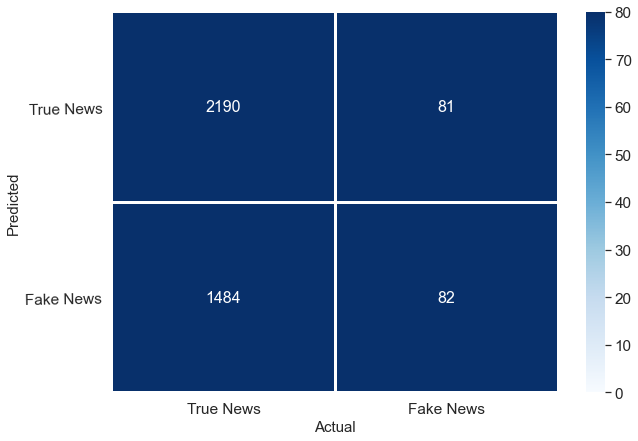

In [81]:
accuracy = modelTraining(MultinomialNB(), X_train4, y_train4, X_test4, y_test4) 
print("accuracy: ", accuracy)

# Applying 5-Fold Cross Validation

from sklearn.model_selection import cross_val_score

scores = cross_val_score(MultinomialNB(), X_train4, y_train4, cv = 5, scoring='accuracy')

print('Cross-validation scores for Multinomial Naive bayes with "BoW" :{}'.format(scores))
print('Average cross-validation score for Multinomial Naive bayes with "BoW" : {:.4f}'.format(scores.mean()))

# Model 05: SVM

# TFIDF

[[1840  431]
 [1132  434]]
59.26505082095387
              precision    recall  f1-score   support

   True News       0.62      0.81      0.70      2271
   Fake News       0.50      0.28      0.36      1566

    accuracy                           0.59      3837
   macro avg       0.56      0.54      0.53      3837
weighted avg       0.57      0.59      0.56      3837

Training set score: 0.7669
Test set score: 0.5927
accuracy:  59.26505082095387
Cross-validation scores for Linear SVM with "BoW" :[0.60301508 0.59798995 0.59408152 0.60670391 0.59329609]
Average cross-validation score for Linear SVM with "BoW" : 0.5990


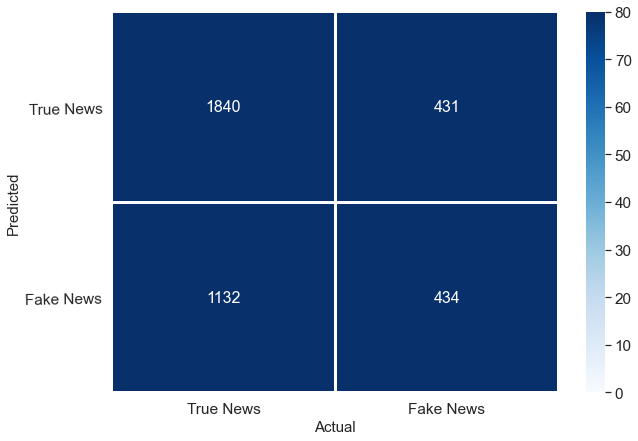

In [82]:
accuracy = modelTraining(svm.SVC(kernel='linear'), X_train3, y_train3, X_test3, y_test3) 

print("accuracy: ", accuracy)


scores = cross_val_score(svm.SVC(kernel='linear'), X_train3, y_train3, cv = 5, scoring='accuracy')

print('Cross-validation scores for Linear SVM with "BoW" :{}'.format(scores))
print('Average cross-validation score for Linear SVM with "BoW" : {:.4f}'.format(scores.mean()))

# TFIDF + Topic

[[1839  432]
 [1129  437]]
59.31717487620537
              precision    recall  f1-score   support

   True News       0.62      0.81      0.70      2271
   Fake News       0.50      0.28      0.36      1566

    accuracy                           0.59      3837
   macro avg       0.56      0.54      0.53      3837
weighted avg       0.57      0.59      0.56      3837

Training set score: 0.7672
Test set score: 0.5932
accuracy:  59.31717487620537
Cross-validation scores for Linear SVM with "BoW" :[0.60022334 0.59519821 0.59687326 0.60446927 0.59329609]
Average cross-validation score for Linear SVM with "BoW" : 0.5980


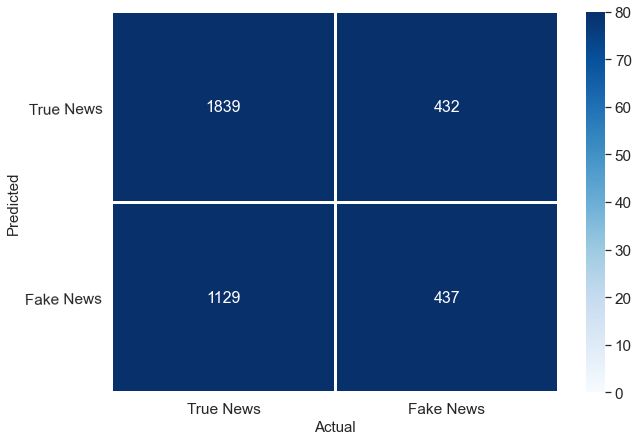

In [83]:
accuracy = modelTraining(svm.SVC(kernel='linear'), X_train4, y_train4, X_test4, y_test4) 

print("accuracy: ", accuracy)


scores = cross_val_score(svm.SVC(kernel='linear'), X_train4, y_train4, cv = 5, scoring='accuracy')

print('Cross-validation scores for Linear SVM with "BoW" :{}'.format(scores))
print('Average cross-validation score for Linear SVM with "BoW" : {:.4f}'.format(scores.mean()))